In [7]:
%matplotlib notebook

#This is just the path to my computer's module directory
import sys
sys.path.append('/usr/local/lib/python2.7/dist-packages')

#Import networkx for graph stuff (based on matplotlib)
import networkx as nx
#Import matplotlib for any plotting
import matplotlib.pyplot as plt
#Import random for creating random numbers
import random
#import scipy and numpy for scientifc calculations, numerics, np.pi=3.141... etc
#import scipy
import numpy as np
import time
import pylab

#from matplotlib import animation

#from JSAnimation import IPython_display

#-----------------------------------------------------------------------------------------
#INPUT PARAMETERS


#Number of Nodes, Eges and possible Opinions in the system, can be modified
NNodes = 3200
NEdges = 6400
NOpinions = 640
Gamma = NNodes/NOpinions #as used in paper

#Probability for process1 = phi,  1-phi for process 2
phi = 0.04

#Time between animation steps
step_time = 0.01

#Number of Iterations for procedure
iter_process = 10000

show_animation = False
#------------------------------------------------------------------------------------------

#Function that initializes Graph
def init_Graph():
    #Create Random Graph
    G = nx.gnm_random_graph(NNodes, NEdges)

    #Assign opinions by random to Node
    for i in range(NNodes):
        G.node[i]["opinion"]= random.randint(0, NOpinions-1)
    
    #Return Graph as G
    return G

def init_equalOpinion_Graph():
    global NOpinions
    NOpinions = 1
    G = init_Graph()
    return G

def check_SelfLoop():
    for i in range(NNodes):
        if G.has_edge(i, i):
            print("Self loop at Node", i)
            sys.exit("report")
            return
    return

In [8]:
#Function that makes a single application of the first process described in the script on the graph:
#"get a new friend who has the same opinion"
#Removes a random connection of a rnd Node  and adds a connection from this node to a node with the same opinion
def process1():
    #Choose random Node
    curr_node = random.randint(0,NNodes-1)
    
    #Get Opinion of current Node
    curr_opinion = G.node[curr_node].get("opinion")
    
   #print("curr_node", curr_node, "degree", G.degree(curr_node), "curr_opinion", curr_opinion)
    check_SelfLoop()
    #Cancel if no Neighbors!
    if G.degree(curr_node)== 0:
        return 
    
    #Choose rnd Neighbor
    ith_neighbor = random.randint(0,G.degree(curr_node)-1)
    try:
        chosen_neighbor = list(G.neighbors(curr_node))[ith_neighbor]
    except Exception:
        print(curr_node, ith_neighbor, list(G.neighbors(curr_node)), G.degree(curr_node))
        print("p1: curr_node, ith_neighbor, G.neighbors, G.degree")
        print(nx.adjacency_matrix(G))
        sys.exit("Error message")
        return
    
    #print("chosen_neighbor", chosen_neighbor)
    


    #Choose rnd Node that has same opinion but is not yet connected
    #Get Nodes with same opinion
    Same_Opinion = [x for x,y in G.nodes(data=True) if y['opinion']== curr_opinion]
    # Remove curr_node from that list
    #print(Same_Opinion)
    #print(curr_node)
    Same_Opinion.remove(curr_node)
    #print(Same_Opinion)
    #Was passiert wenn mit allen bereits verbunden?

    
    #iterate through list
    for i in enumerate(Same_Opinion):
        #exclude: No more unconnected nodes with same opinion
        if len(Same_Opinion) == 0:
            return
        #print("Same Opinion", Same_Opinion)
        #pick random node with same opinion
        newNeighbor = random.choice(Same_Opinion)
        #if Node is already connected, delete node from list and continue
        if G.has_edge(curr_node, newNeighbor):
            Same_Opinion.remove(newNeighbor)
        #if not break
        else:
            break
   
    #NONEWNEIGHBOR
    try:
        newNeighbor
    except NameError:
        return
    #Remove Edge between Current Node and neighbor
    old_edge = (curr_node, chosen_neighbor)
    G.remove_edge(*old_edge)
    
    #print("create edge between", curr_node, newNeighbor)
    #Add Edge between current Node and newNeighbor
    new_edge = (curr_node, newNeighbor)
    G.add_edge(*new_edge)
    
    return

In [9]:
#Second process
#"changes opinions of friends"
#Picks Random Node, picks neighbour of random node, adapts neighbours' opinion
def process2():
    #Choose random Node
    curr_node = random.randint(0,NNodes-1)
    
    #Get Opinion of current Node
    curr_opinion = G.node[curr_node].get("opinion")
    
    #print("curr_node", curr_node, "degree", G.degree(curr_node), "curr_opinion", curr_opinion)
    
    #Cancel if no Neighbors!
    if G.degree(curr_node)== 0:
        return 
    
    #get neighbor of curr_node
    ith_neighbor = random.randint(0, G.degree(curr_node)-1)
    try:
        chosen_neighbor = list(G.neighbors(curr_node))[ith_neighbor]
    except Exception:
        print(curr_node, ith_neighbor, list(G.neighbors(curr_node)), G.degree(curr_node))
        print("p2: curr_node, ith_neighbor, G.neighbors, G.degree")
        print(nx.adjacency_matrix(G))
        sys.exit("Error message")
    #set opinion of neighbor to opinion of curr node
    G.node[chosen_neighbor]["opinion"] = curr_opinion
    return

In [10]:
#checks if everyone is only connected to nodes of same opinion (in a slow way)
#does it actually work?????
def check_consensus():
    print("check")
    #for every node
    for curr_node in G.nodes:
        print(curr_node)
        #for each neighbor
        for neighbor in G.neighbors(curr_node):
            print(neighbor)
            #if they don't agree -> no consensus state
            if G.node[chosen_neighbor]["opinion"] != G.node[curr_node]["opinion"]:
                return 0
    #if all tests passed -> consensus state
    return 1

def check_consensus2():
    #creates subgraphs for all connected components -> slow?
    subs = list(nx.connected_component_subgraphs(G))
    #for each subgraph
    for i, curr_sub in enumerate(subs):
        #create list of opinions
        curr_opinions = list(nx.get_node_attributes(curr_sub,'opinion').values())
        #check if all elements are equal (= if the first element appears len(list) times)
        if (curr_opinions.count(curr_opinions[0]) != len(curr_opinions)):
            return 0
    return 1

def print_data():
    #get subgraphs
    subs = list(nx.connected_component_subgraphs(G))
    
    #create numpy array with integer values from 1 to nnodes
    #x_Nodes = np.arange(1, NNodes+1)
    
    #should simply use plt.hist instead!!
    y_Subgraph = np.full(NNodes, 0)
    for curr_sub in subs:
        y_Subgraph[curr_sub.number_of_nodes()] +=1
    fig, ax = plt.subplots()
    #subsizes = plt.plot(x_Nodes, y_Subgraph, 'ro')
    subsizes = plt.hist(y_Subgraph, bins = NNodes, facecolor = 'g', alpha=0.75)
    plt.xlabel('Number of Nodes in Subgraph')
    plt.ylabel('Appearences in Consensus State')
    plt.title("Sizes of Subgraphs")
    plt.ylim(ymin=0.5)
    plt.autoscale(enable = True)
    plt.set_xscale("log")
    plt.show()

<IPython.core.display.Javascript object>


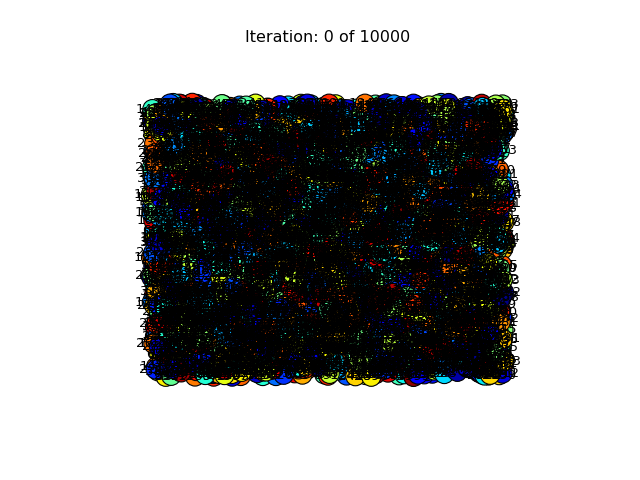

/usr/local/lib/python3.5/dist-packages/matplotlib/backend_bases.py:2437: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [ ]:
pylab.ion()
G = init_Graph()
pos = nx.layout.random_layout(G)

def get_fig(curr_iter):
    plt.clf()
    plt.axis('off')
    curr_title = "Iteration: "+str(curr_iter) +" of " + str(iter_process)
    plt.title(curr_title)
    nx.draw_networkx_edges(G, pos) 
    nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G,'opinion').values()))
    nx.draw_networkx_labels(G, pos=pos)
    pylab.draw()
    time.sleep(step_time)
    try:
        plt.pause(0.1)
    except Exception:
        pass
    
    #nx.draw(G)

pylab.show()

plt.axis('off')
get_fig(0)
p1counter = 0
p2counter = 0

for i in range(iter_process):
    if check_consensus2() == 1:
        print("CONSENSUS STATE after iteration", i)
        break
    if random.uniform(0, 1) < phi:
        process1()
        p1counter +=1
    else:
        process2()
        p2counter +=1
    if show_animation:
        get_fig(i)
#show final state in any case:
get_fig(i)

print_data()
    
